# League Of Legends Stat analyses

This project makes you able to get a clear insight in your own, or someone else their League of Legends stats!

#### Importing data from different files to be able to run the code.

In [1]:
from lol_data import get_summoner_lol_data, get_match_ids, get_match_data, calculate_win_percentage_per_role, calculate_champion_synergy, get_top_champions
from lol_visuals import visualize_win_percentages, plot_win_percentage_over_time, visualize_champion_stats, create_table_visual, visualize_champion_synergy
from azure_db_writer import WinrateTable, generate_unique_id, SynergyTable, SummonerDataTable, MatchDataTable
from config import API_KEY
import pyodbc


summoner_name = input("Enter Summoner Name: ")
region = input("Enter Region (e.g., na1, euw1): ")
queue_type = input("Enter Queue Type (e.g., ranked_solo_duo): ")

summoner_data = get_summoner_lol_data(API_KEY, summoner_name, region)
match_ids = get_match_ids(API_KEY, summoner_data['puuid'], region, queue_type, count=50)
if summoner_data:
    print(f"Summoner name: {summoner_data['name']}")
    print(f"Summoner Level: {summoner_data['summonerLevel']}")
    print(f"Below is the data analyses for {summoner_name} in {queue_type}:")
    summoner_puuid = summoner_data['puuid']
    match_ids = get_match_ids(API_KEY, summoner_data['puuid'], region, queue_type)
    if match_ids:
        matches = []
        for match_id in match_ids:
            match_data = get_match_data(API_KEY, match_id, region)
            if match_data:
                matches.append(match_data)
            else:
                print(f"Error fetching match data for match ID {match_id}")

Summoner name: Kiirbb
Summoner Level: 282
Below is the data analyses for kiirbb in ranked_solo_duo:


#### Loading data to database

In [2]:
# Connecting to database
try:
    conn = pyodbc.connect("Driver={ODBC Driver 18 for SQL Server};Server=tcp:jarvis-cloud-verzamelen-joram.database.windows.net,1433;Database=BitAcademyDB;Uid=152791@student.horizoncollege.nl;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;Authentication=ActiveDirectoryInteractive")
    cursor = conn.cursor()
except pyodbc.Error as e:
    print(f"Error connecting to database: {e}")

# Fetch the top champions
top_champions = get_top_champions(matches, summoner_data['puuid'], num_top_champions=3)

# Calculate champion synergy
champion_synergy = calculate_champion_synergy(matches, summoner_data['puuid'], top_champions)

# Update WinrateTable
WinrateTable(matches, summoner_data, summoner_name, queue_type, cursor, conn)

# Update SynergyWRTable
unique_id = generate_unique_id(summoner_name, queue_type)
SynergyTable(unique_id, champion_synergy, cursor, conn)

SummonerDataTable(unique_id, summoner_data, queue_type, cursor, conn)
MatchDataTable(unique_id, matches, summoner_puuid, cursor, conn)



Winrates added to the database!
Synergy-Table filled with data!
Summoner data added to the database!
Match data added to Match-Data-Table!


#### Win percentage per role

Below you can see the winpercentage of each role.

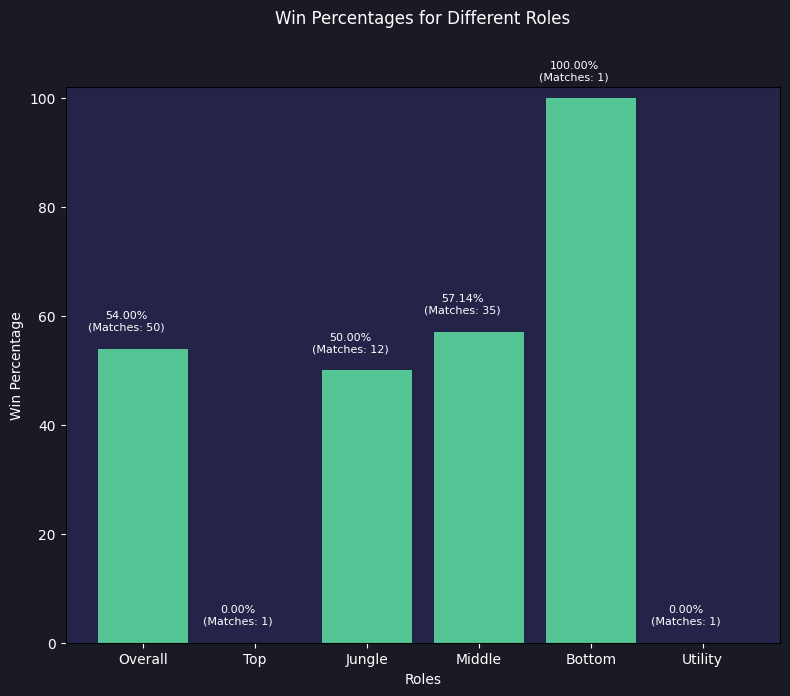

In [3]:
win_percentages = calculate_win_percentage_per_role(matches, summoner_data['puuid'])
visualize_win_percentages(win_percentages)

With this barchart you can see what role leads to the most wins for you as a player. This data is based on the last 50 matches you have played in the selected gamemode.

#### Win percentage from the last 2 weeks

Below you get a clear visual that shows you the improvement you made in the last 2 weeks based on win percentage.

Total games in the last two weeks for this queue type: 34


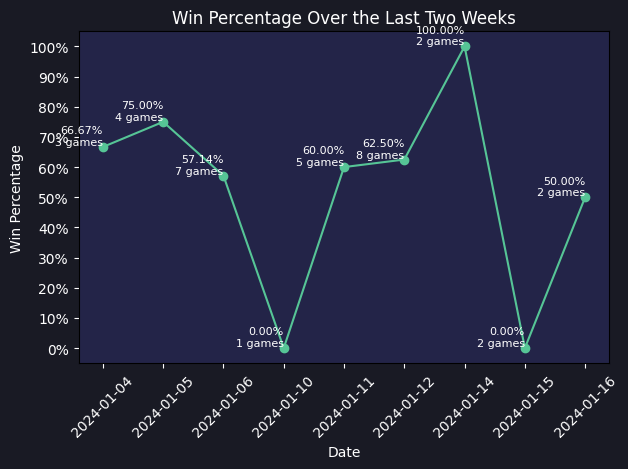

In [4]:
plot_win_percentage_over_time(matches, summoner_data)

In this lineplot you get to see how many games you played on each specific day in the last 2 weeks. We calculated the overall winrate for each day to give you a good idea how much you have improved in the last 2 weeks. 

#### Winrate per champion

Below we created a barplot that shows the winrate for each champion you played in the last 50 games.

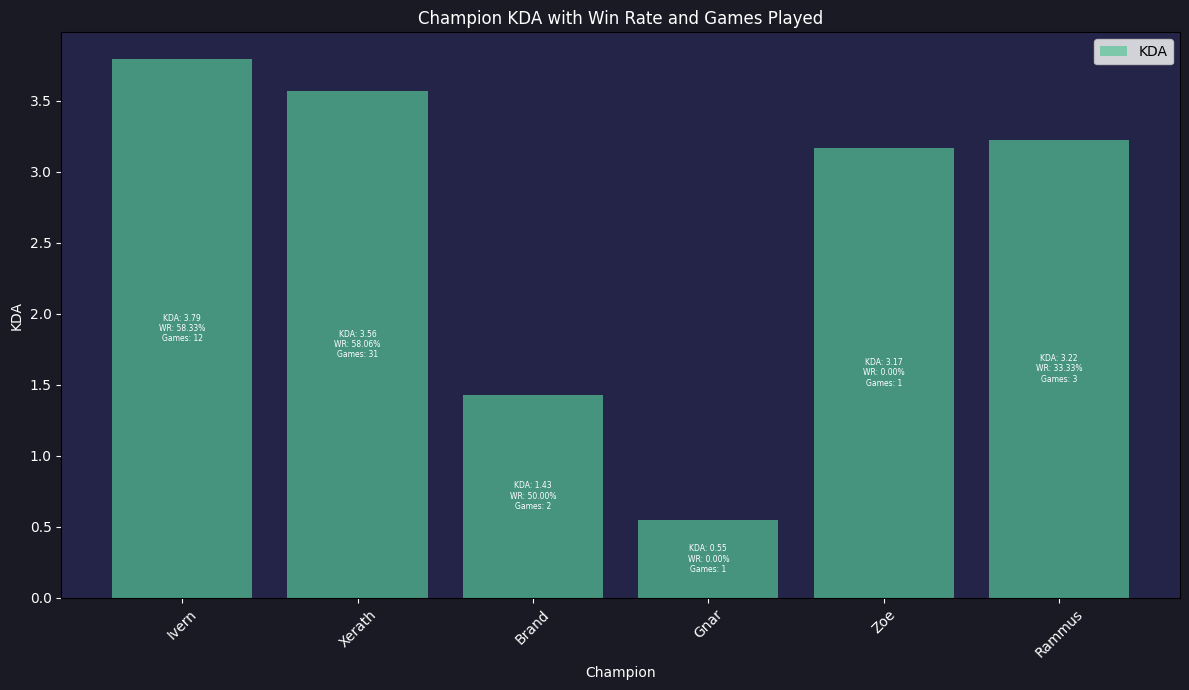

In [5]:
visualize_champion_stats(matches, summoner_data)

This barplot gives you a idea what champions have been working best for you in the last 50 games. 

#### Best item build per per champion

In this table we calculated the winrate for each champion per specific item order.

In [6]:
create_table_visual(matches, summoner_data['puuid'])

This table shows you what item build has worked best in most of your games. Each item build might work different against each enemy team. But this table gives you a overall view of what item order has worked best for you in the last 50 games.

#### Synergy for your top 3 champions

We calculated the synergy for your top 3 most played champions from the last 50 games.

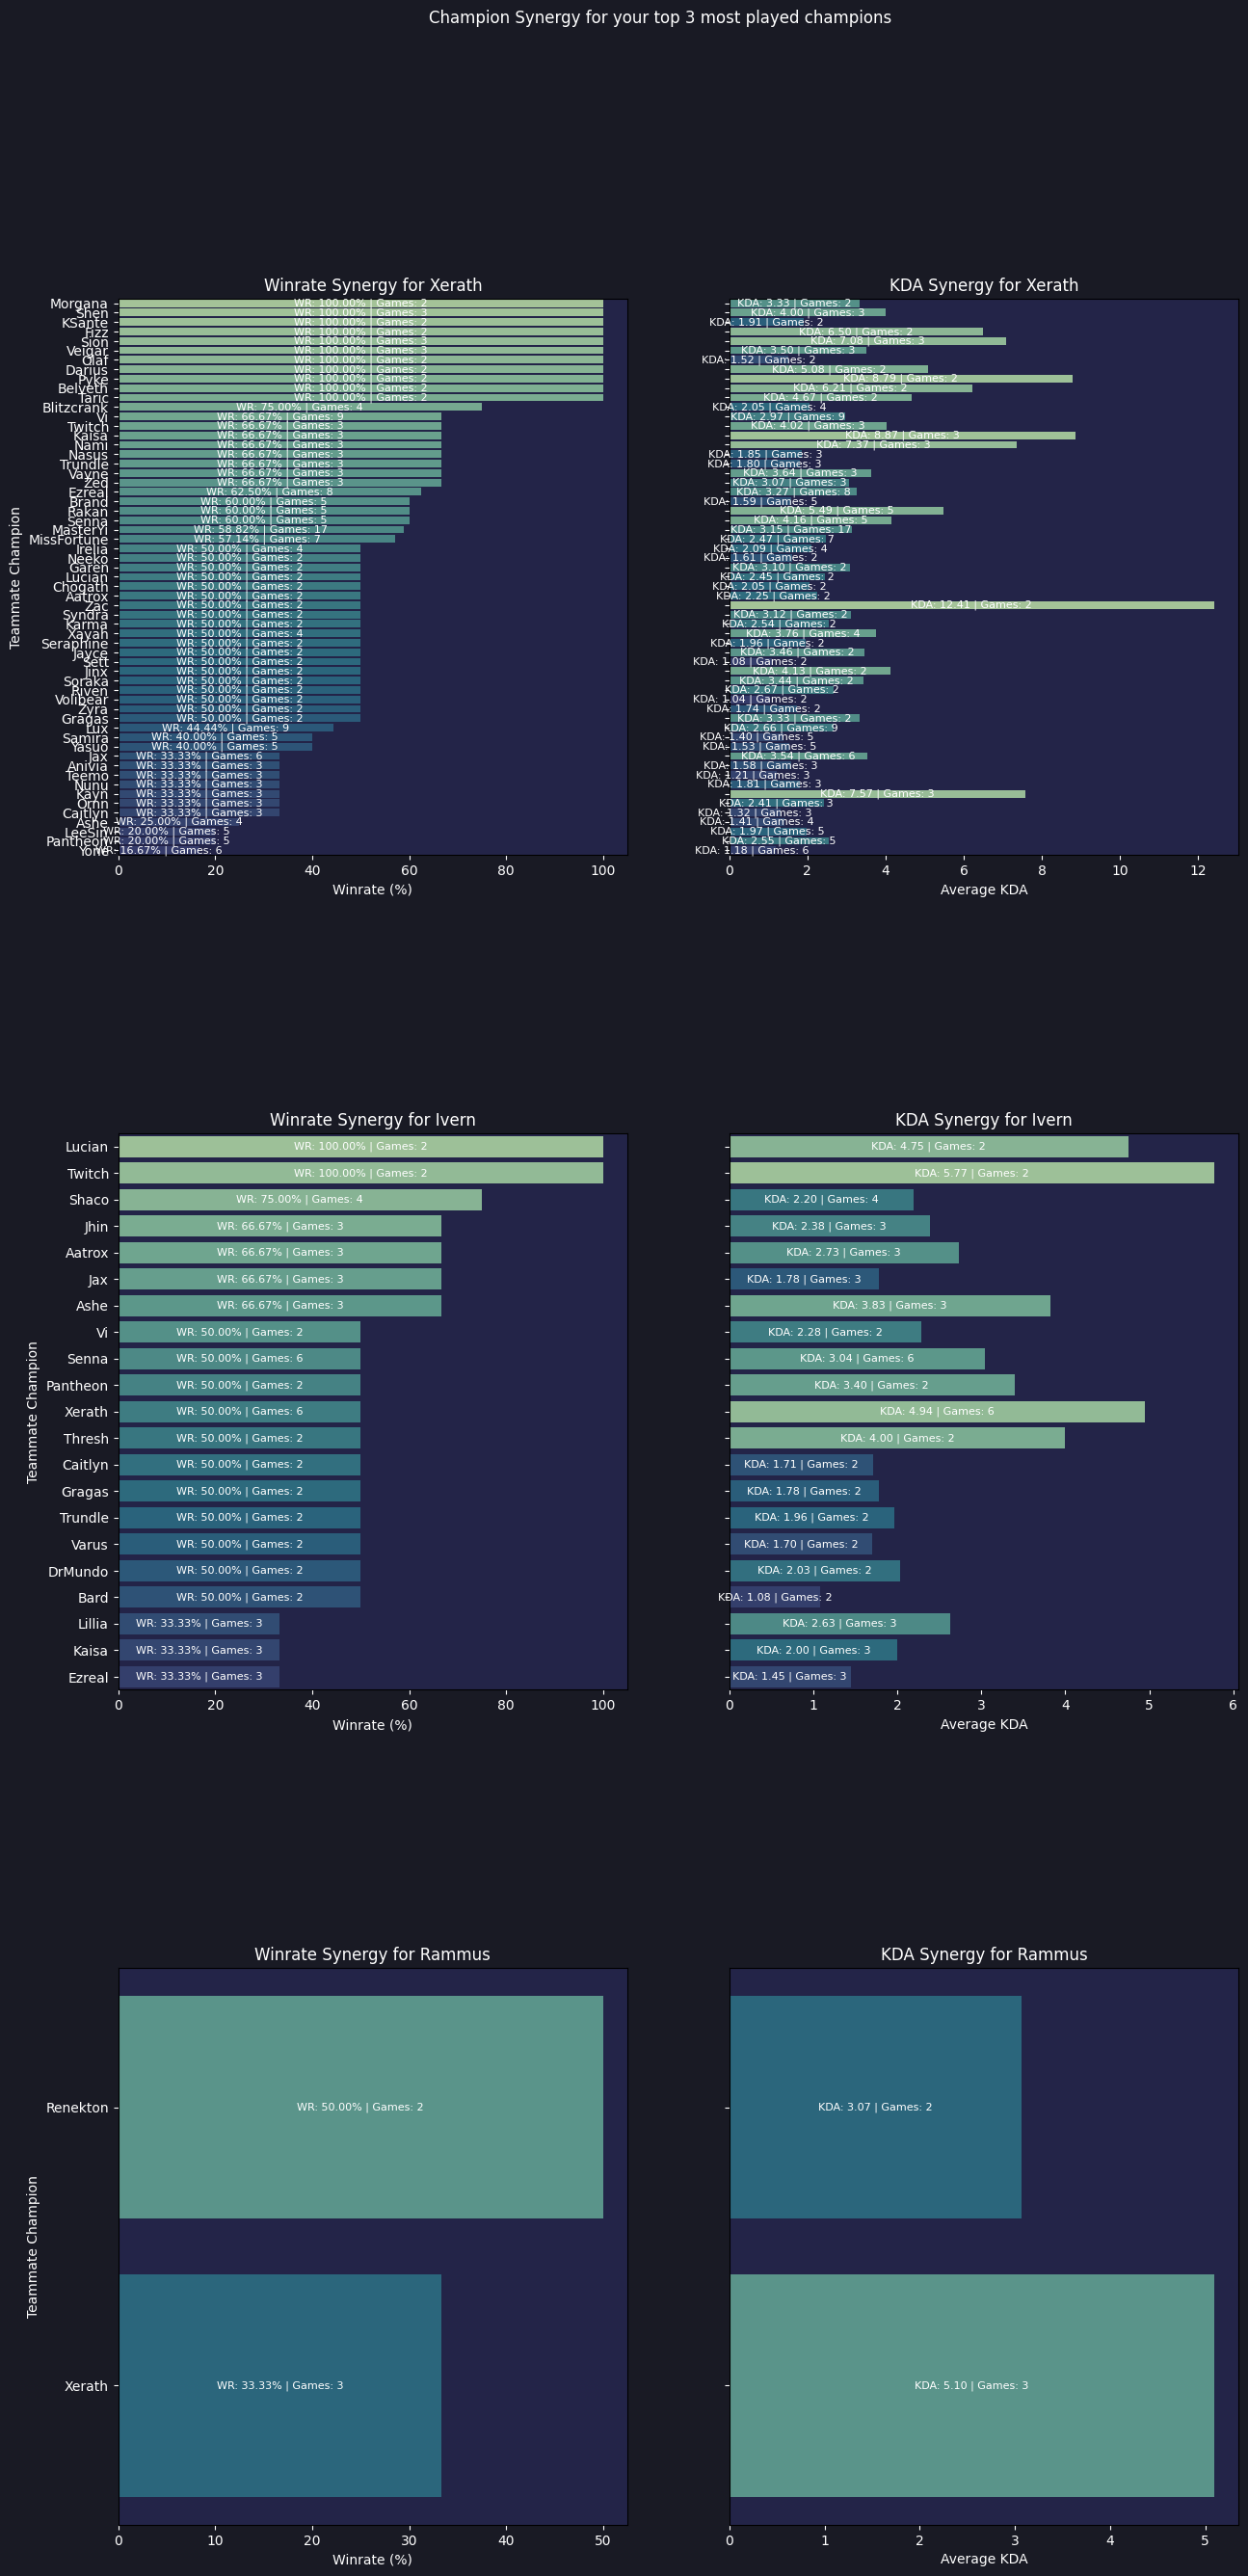

In [ ]:
top_champions = get_top_champions(matches, summoner_data['puuid'], num_top_champions=3)
champion_synergy = calculate_champion_synergy(matches, summoner_data['puuid'], top_champions)
visualize_champion_synergy(champion_synergy, top_champions, min_games_played=2)


These plots shows you what champions have been working best with your top 3 champions. This is based on both winrate and KDA. Choosing a champion with the highest winrate and highest KDA for your duo partner might result in more wins!